In [2]:
using LogicCircuits
using ProbabilisticCircuits
using DataFrames
using BenchmarkTools
using TikzPictures
using Statistics: mean
using LinearAlgebra: normalize
using Clustering: kmeans, nclusters, assignments
TikzPictures.standaloneWorkaround(true)

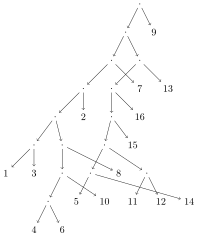

In [3]:
train_x, valid_x, test_x = twenty_datasets("nltcs")
pc_cl, vtree_cl = learn_chow_liu_tree_circuit(train_x)
plot(vtree_cl)

In [96]:
import Printf

using LogicCircuits.LoadSave: SDDElement, 
    PSDDElement, 
    save_lines,
    get_vtree2id,
    get_node2id,
    parse_psdd_file, 
    PsddHeaderLine, 
    LcHeaderLine, 
    get_nodes_level


nd = 1000
d = train_x[1:nd,:] # Using fewer data for quicker tests
vtree = vtree_cl

function bs2arr(bs)
    y = variables(bs) # parsing the indexes of the variables on the right DEBUG: case of a single var
    yy = (x->collect.(x)).(y)
    b = zeros(Int8,size(yy,1))
    for i = 1:size(yy,1)
        b[i] = yy[i][1]
    end
    return b
end

function lr(vtree)
    if typeof(vtree.left) == PlainVtreeLeafNode && typeof(vtree.right) == PlainVtreeLeafNode
        l = [variable(vtree.left)+1-1]
        r = [variable(vtree.right)+1-1] 
    elseif typeof(vtree.left) == PlainVtreeLeafNode
        l = [variable(vtree.left)+1-1]
        r = bs2arr(vtree.right)
    else
        l = bs2arr(vtree.left)
        r = bs2arr(vtree.right)
    end    
    return [l,r]
end

const NCLUSTERS = 3
DB_TITLE = names(d)
const MINCLUSTERSIZE = 3
DICT_VTREE = get_vtree2id(vtree)


function find_names(names_short,indexes_short)
    m=Any[]
    for i in indexes_short
        push!(m,findfirst(x->x==DB_TITLE[i], names_short))
    end
    return m
end

function clustering2(data, mix_num::Int64; maxiter=200)::Vector
    n = num_examples(data)
    if mix_num == 1
        return [data]
    end
    data = Matrix(data)
    R = kmeans(data', mix_num; maxiter=maxiter)
    @assert nclusters(R) == mix_num
    a = assignments(R)

    clustered_data = Vector()
    for k in 1 : mix_num
        push!(clustered_data, DataFrame(data[findall(x -> x == k, a), :]))
    end
    return [clustered_data,a]
end


function LearnDecision(d,v,myrows, parent="", element="", sibling=0)
    indx = size(myrows,1)
    index_var = Int16(DICT_VTREE[v])
    if typeof(v) == PlainVtreeLeafNode # Leaf, nothing to do, just write L or T
        var = Int16(variable(v))
        nt = count(i->(i == true), d[:,1])
        if nt == size(d,1)
            myrow = ["L",indx,index_var,var,var,parent,element,sibling]
            append!(myrows,[myrow])
        elseif nt == 0
            myrow = ["L",indx,index_var,var,-var,parent,element,sibling]            
            append!(myrows,[myrow])
        else
            p = nt/size(d,1)
            myrow = ["T",indx,index_var,var,p,parent,element,sibling]
            append!(myrows,[myrow])
        end
    else
        variables = lr(v) # Let's find right and left variables
        for i = 1:2
            variables[i] = find_names(names(d),variables[i])
        end
        if size(variables[1],1) == 1 
            if size(variables[2],1) > 1 # CASE 1: Single var on the left, many on the right
                dd = [filter(row -> row[variables[1][1]] == i, d) for i in 0:1]
                dd_left1 = dd[1][:,variables[1]]
                dd_right1 = dd[1][:,variables[2]]
                dd_left2 = dd[2][:,variables[1]]
                dd_right2 = dd[2][:,variables[2]]
                p = [size(dd[i],1)/size(d,1) for i in 1:2]
                sub1 = -1
                sub2 = -1
                prime1 = -1
                prime2 = -1
                myrow = ["D",indx,index_var,prime1,sub1,p[1],prime2,sub2,p[2],parent,element,sibling]
                append!(myrows,[myrow])
                LearnDecision(dd_left1,v.left,myrows,indx,"left",1)
                LearnDecision(dd_left2,v.left,myrows,indx,"left",2)
                LearnDecision(dd_right1,v.right,myrows,indx,"sub",1)
                LearnDecision(dd_right2,v.right,myrows,indx,"sub",2)
            end
        else
            if size(d,1) > MINCLUSTERSIZE
                d_left = d[:,variables[1]]
                d_right = d[:,variables[2]]
                clsts2 = clustering2(d_left,NCLUSTERS)
                clsts = clsts2[1]
                assignments = clsts2[2]
                p = [size(clsts[c],1)/size(d,1) for c = 1:NCLUSTERS]
                numberofelements = NCLUSTERS
                prime1 = -1
                prime2 = -1
                prime3 = -1
                sub1 = -1
                sub2 = -1
                sub3 = -1
                myrow = ["D",indx,index_var,NCLUSTERS,prime1,sub1,p[1],prime2,sub2,p[2],prime3,sub3,p[3],parent,element,sibling]
                append!(myrows,[myrow])
                for c = 1:NCLUSTERS
                    rename!(clsts[c],names(d_left))
                    LearnDecision(clsts[c],v.left,myrows,indx,"prime",c)
                    d2 = d_right[findall(x->x==c, assignments),:]
                    LearnDecision(d2,v.right,myrows,indx,"sub",c)
                end
            end
        end
    end
    return myrows
end

function cleaner(rows)
    for (r,row) in enumerate(rows)
        goodrow = row
        if row[1] == "D"
            candidates = Any[]
            pp = row[2]
            for row2 in rows
                if pp == row2[length(row2)-2]
                    append!(candidates,[row2])
                end
            end
            if length(candidates) == 4
                for candidate in candidates
                    if candidate[length(candidate)] == 1 && candidate[length(candidate)-1] == "left"
                        row[4] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 1 && candidate[length(candidate)-1] == "sub"
                        row[5] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 2 && candidate[length(candidate)-1] == "left"
                        row[7] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 2 && candidate[length(candidate)-1] == "sub"
                        row[8] = candidate[2]                
                    end
                end
                goodrow = row[1:9]
            elseif length(candidates) == 6
                for candidate in candidates
                    println(candidate)
                    if candidate[length(candidate)] == 1 && candidate[length(candidate)-1] == "left"
                        row[5] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 1 && candidate[length(candidate)-1] == "sub"
                        row[6] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 2 && candidate[length(candidate)-1] == "left"
                        row[8] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 2 && candidate[length(candidate)-1] == "sub"
                        row[9] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 3 && candidate[length(candidate)-1] == "left"
                        row[11] = candidate[2]                
                    end
                    if candidate[length(candidate)] == 3 && candidate[length(candidate)-1] == "sub"
                        row[12] = candidate[2]                
                    end
                end
                goodrow = row[1:13]
            end
            rows[r] = goodrow
        end
    end
    return rows
end


#open("myfile.txt", "w") do io
#file = zoo_psdd_file("little_4var.psdd")
#print(file)
#prob_circuit = load_prob_circuit(file);
#rows = ["c 1","c 2"]
rroowwss = LearnDecision(d,vtree,[])


rr = cleaner(rroowwss)



for o in rr
    println(o) #join(o))
end
#print(Int8(DICT_VTREE[vtree]))
#end
#println("Finito")
#println(vtree)
#println(variables(vtree))
#println(vtree.left)
#println(isinner(vtree.left))
#println(isinner(vtree.right))
#println(varsubset(vtree.right,vtree))
#println(root(vtree.left))
#println(get_vtree2id(vtree.left))
#dd = get_vtree2id(vtree)
#print(dd[vtree.right])
#println(variables(vtree.left))
#println(vtree.right)
#println(variables(vtree.right))
#vr = vtree.right
#print(vr.parent)
#I'm long: $x, but I'm alright: $(@sprintf("%.2f", x))")


Any["D", 4, 15, -1, -1, 0.9867549668874173, -1, -1, 0.013245033112582781, 3, "prime", 1]
Any["D", 63, 28, -1, -1, 0.9470198675496688, -1, -1, 0.052980132450331126, 3, "sub", 1]
Any["D", 99, 15, -1, -1, 0.3978494623655914, -1, -1, 0.6021505376344086, 3, "prime", 2]
Any["D", 192, 28, -1, -1, 0.7526881720430108, -1, -1, 0.24731182795698925, 3, "sub", 2]
Any["D", 228, 15, -1, -1, 0.9063670411985019, -1, -1, 0.09363295880149813, 3, "prime", 3]
Any["D", 303, 28, -1, -1, 0.850187265917603, -1, -1, 0.149812734082397, 3, "sub", 3]
Any["D", 67, 25, -1, -1, 0.993421052631579, -1, -1, 0.006578947368421052, 66, "prime", 1]
Any["L", 71, 26, 16, -16, 66, "sub", 1]
Any["D", 72, 25, -1, -1, 0.6619718309859155, -1, -1, 0.3380281690140845, 66, "prime", 2]
Any["L", 77, 26, 16, -16, 66, "sub", 2]
Any["D", 78, 25, -1, -1, 0.9074074074074074, -1, -1, 0.09259259259259259, 66, "prime", 3]
Any["T", 83, 26, 16, 0.018518518518518517, 66, "sub", 3]
Any["D", 85, 25, -1, -1, 0.0, -1, -1, 1.0, 84, "prime", 1]
Any["T"

Any["L", 59, 6, 8, 8, 57, "left", 2]
Any["D", 60, 12, -1, -1, NaN, -1, -1, NaN, 49, "sub", 3]
Any["L", 61, 6, 8, 8, 60, "left", 1]
Any["L", 62, 6, 8, 8, 60, "left", 2]
Any["D", 63, 28, 64, 66, 0.9470198675496688, 65, 84, 0.052980132450331126]
Any["L", 64, 16, 13, -13, 63, "left", 1]
Any["L", 65, 16, 13, 13, 63, "left", 2]
Any["D", 66, 27, 3, -1, 71, 0.7086247086247086, -1, 77, 0.1655011655011655, -1, 83, 0.1258741258741259]
Any["D", 67, 25, -1, -1, 0.993421052631579, -1, -1, 0.006578947368421052, 66, "prime", 1]
Any["L", 68, 17, 15, -15, 67, "left", 1]
Any["L", 69, 17, 15, 15, 67, "left", 2]
Any["D", 70, 24, 3, -1, -1, 0.9370860927152318, -1, -1, 0.04304635761589404, -1, -1, 0.019867549668874173, 67, "sub", 1]
Any["L", 71, 26, 16, -16, 66, "sub", 1]
Any["D", 72, 25, 73, 75, 0.6619718309859155, 74, 76, 0.3380281690140845]
Any["L", 73, 17, 15, -15, 72, "left", 1]
Any["L", 74, 17, 15, 15, 72, "left", 2]
Any["D", 75, 24, 3, -1, -1, 0.6170212765957447, -1, -1, 0.14893617021276595, -1, -1, 0

Any["L", 221, 17, 15, 15, 219, "left", 2]
Any["D", 222, 24, 3, -1, -1, 0.6, -1, -1, 0.1, -1, -1, 0.3, 219, "sub", 1]
Any["T", 223, 26, 16, 0.2, 213, "sub", 2]
Any["D", 224, 25, -1, -1, 1.0, -1, -1, 0.0, 213, "prime", 3]
Any["L", 225, 17, 15, -15, 224, "left", 1]
Any["L", 226, 17, 15, 15, 224, "left", 2]
Any["L", 227, 26, 16, -16, 213, "sub", 3]
Any["D", 228, 15, 229, 231, 0.9063670411985019, 230, 282, 0.09363295880149813]
Any["L", 229, 1, 7, -7, 228, "left", 1]
Any["L", 230, 1, 7, 7, 228, "left", 2]
Any["D", 231, 14, 232, 234, 0.9173553719008265, 233, 264, 0.08264462809917356]
Any["L", 232, 2, 2, -2, 231, "left", 1]
Any["L", 233, 2, 2, 2, 231, "left", 2]
Any["D", 234, 13, 3, -1, -1, 0.8513513513513513, -1, -1, 0.10810810810810811, -1, -1, 0.04054054054054054, 231, "sub", 1]
Any["D", 235, 12, 236, 238, 0.7195767195767195, 237, 242, 0.2804232804232804]
Any["L", 236, 6, 8, -8, 235, "left", 1]
Any["L", 237, 6, 8, 8, 235, "left", 2]
Any["D", 238, 11, 3, -1, -1, 0.5661764705882353, -1, -1, 0

Any["L", 387, 17, 15, -15, 386, "left", 1]
Any["L", 388, 17, 15, 15, 386, "left", 2]
Any["D", 389, 24, 3, -1, -1, 0.6, -1, -1, 0.2, -1, -1, 0.2, 386, "sub", 1]
Any["L", 390, 26, 16, -16, 385, "sub", 1]
Any["D", 391, 25, -1, -1, 1.0, -1, -1, 0.0, 385, "prime", 2]
Any["L", 392, 17, 15, -15, 391, "left", 1]
Any["L", 393, 17, 15, 15, 391, "left", 2]
Any["D", 394, 24, 3, -1, -1, 0.6, -1, -1, 0.4, -1, -1, 0.0, 391, "sub", 1]
Any["L", 395, 26, 16, -16, 385, "sub", 2]
Any["D", 396, 25, -1, -1, 0.0, -1, -1, 1.0, 385, "prime", 3]
Any["L", 397, 17, 15, 15, 396, "left", 1]
Any["L", 398, 17, 15, 15, 396, "left", 2]
Any["D", 399, 24, 3, -1, -1, 0.75, -1, -1, 0.16666666666666666, -1, -1, 0.08333333333333333, 396, "sub", 2]
Any["T", 400, 26, 16, 0.25, 385, "sub", 3]
Any["D", 401, 27, 3, -1, 406, 0.8461538461538461, -1, 410, 0.038461538461538464, -1, 414, 0.11538461538461539]
Any["D", 402, 25, -1, -1, 0.0, -1, -1, 1.0, 401, "prime", 1]
Any["L", 403, 17, 15, 15, 402, "left", 1]
Any["L", 404, 17, 15, 15,

Any["L", 549, 17, 15, 15, 548, "left", 1]
Any["L", 550, 17, 15, 15, 548, "left", 2]
Any["L", 551, 26, 16, -16, 537, "sub", 3]
Any["D", 552, 27, 3, -1, 557, 0.847457627118644, -1, 561, 0.03389830508474576, -1, 566, 0.11864406779661017]
Any["D", 553, 25, -1, -1, 0.06, -1, -1, 0.94, 552, "prime", 1]
Any["L", 554, 17, 15, -15, 553, "left", 1]
Any["L", 555, 17, 15, 15, 553, "left", 2]
Any["D", 556, 24, 3, -1, -1, 0.8723404255319149, -1, -1, 0.1276595744680851, -1, -1, 0.0, 553, "sub", 2]
Any["T", 557, 26, 16, 0.7, 552, "sub", 1]
Any["D", 558, 25, -1, -1, 0.0, -1, -1, 1.0, 552, "prime", 2]
Any["L", 559, 17, 15, 15, 558, "left", 1]
Any["L", 560, 17, 15, 15, 558, "left", 2]
Any["T", 561, 26, 16, 0.5, 552, "sub", 2]
Any["D", 562, 25, -1, -1, 0.8571428571428571, -1, -1, 0.14285714285714285, 552, "prime", 3]
Any["L", 563, 17, 15, -15, 562, "left", 1]
Any["L", 564, 17, 15, 15, 562, "left", 2]
Any["D", 565, 24, 3, -1, -1, 0.6666666666666666, -1, -1, 0.16666666666666666, -1, -1, 0.16666666666666666,